In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
from sklearn.decomposition import PCA
data = pd.read_csv("pinsoro-2017-06-12-140651300755-small.csv", low_memory=False)

x = np.array(data.iloc[:,11:195]).astype(float)
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T


dt = 0.001

def extract_pattern(start, end):
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/dt))*dt
    
    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T
    
    return t, result


t1, result1 = extract_pattern(10175, 10280) #goaloriented
t2, result2 = extract_pattern(22854, 23059) #noplay
t3, result3 = extract_pattern(13811, 14182) #goaloriented
t4, result4 = extract_pattern(9796, 10174) #noplay 
t5, result5 = extract_pattern(22753, 22853) #goaloriented 
t6, result6 = extract_pattern(14583, 14991) #noplay

#np.savetxt('result.csv', result1, delimiter=',')
#result1.shape


Cumulative explained variance: [0.42369679]


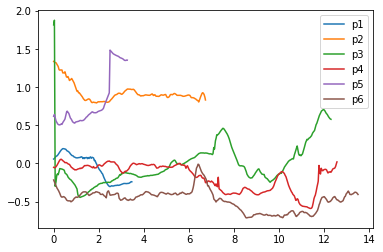

In [3]:
nb_components=1
train_all = np.vstack([result1, result2, result3, result4, result5, result6])
pca_model = PCA(n_components=nb_components).fit(train_all)
print("Cumulative explained variance: %s" % pca_model.explained_variance_ratio_.cumsum())

p1 = pca_model.transform(result1)[:,0]
p2 = pca_model.transform(result2)[:,0]
p3 = pca_model.transform(result3)[:,0]
p4 = pca_model.transform(result4)[:,0]
p5 = pca_model.transform(result5)[:,0]
p6 = pca_model.transform(result6)[:,0]

plt.plot(t1, p1, label='p1')
plt.plot(t2, p2, label='p2')
plt.plot(t3, p3, label='p3')
plt.plot(t4, p4, label='p4')
plt.plot(t5, p5, label='p5')
plt.plot(t6, p6, label='p6')
plt.legend()


Pattern 1 is goal oriented play. 
Pattern 2 is no-play. 

Now let's create a network that represents a rolling window in time (Aaron's "delay network"). The process determines what sort of pattern the network will be optimized for -- here we just go with white noise of a maximum of 3Hz.  theta determines how big the rolling window is -- here we use 0.5 seconds.

In [4]:
theta = 1.0

net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
    rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=2000, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Now we need to create the training data for decoding out of the rolling window. Our patterns are larger than the rolling window, so to create our training data we will take our patterns, shift them, and cut them down to the right size. In order to then give that to nengo, we also need to project from the window's space to the internal representation space (using the inv_basis).

The target array is the desired output value for each of the slices of the pattern in eval_points. We'll use 1 for pattern1 and -1 for pattern2.

In [5]:
s_window = int(theta/dt)
print(s_window)
s_pattern = min(len(p1), len(p2), len(p3), len(p4), len(p5), len(p6))

t_window = np.linspace(0, 1, s_window)
inv_basis = rw.inverse_basis(t_window)
    
eval_points=[]
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(p1, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(p2, i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(p3, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(p4, i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(p5, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(p6, i)[:s_window]))
    target.append([-1])
    
eval_points = np.array(eval_points)
print(eval_points.shape)

1000
(19596, 6)


Now we can create a connection optimized to do this decoding

In [6]:
with net:
    result = nengo.Node(None, size_in=1)
    nengo.Connection(rw.state, result,
                     eval_points=eval_points, scale_eval_points=True,
                     function=target, synapse=0.1)

Let's try feeding in those two patterns and see what the response is

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

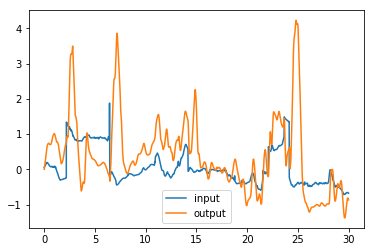

In [7]:
p_all = np.hstack([p1, p2, p3, p4, p5, p6])

presentation_time_train=0.00063

model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_train))
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(30)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

In [8]:
p1_len = int(len(p1)*presentation_time_train/dt)
p2_len = p1_len+int(len(p2)*presentation_time_train/dt)
p3_len = p2_len+int(len(p3)*presentation_time_train/dt)
p4_len = p3_len+int(len(p4)*presentation_time_train/dt)
p5_len = p4_len+int(len(p5)*presentation_time_train/dt)
p6_len = p5_len+int(len(p6)*presentation_time_train/dt)

mean1 = np.mean(sim.data[p_result][0:p1_len])
std1 = np.std(sim.data[p_result][0:p1_len])
median1 = np.median(sim.data[p_result][0:p1_len])
mean2 = np.mean(sim.data[p_result][p1_len:p2_len])
std2 = np.std(sim.data[p_result][p1_len:p2_len])
median2 = np.median(sim.data[p_result][p1_len:p2_len])
mean3 = np.mean(sim.data[p_result][p2_len:p3_len])
std3 = np.std(sim.data[p_result][p2_len:p3_len])
median3 = np.median(sim.data[p_result][p2_len:p3_len])
mean4 = np.mean(sim.data[p_result][p3_len:p4_len])
std4 = np.std(sim.data[p_result][p3_len:p4_len])
median4 = np.median(sim.data[p_result][p3_len:p4_len])
mean5 = np.mean(sim.data[p_result][p4_len:p5_len])
std5 = np.std(sim.data[p_result][p4_len:p5_len])
median5 = np.median(sim.data[p_result][p4_len:p5_len])
mean6 = np.mean(sim.data[p_result][p5_len:p6_len])
std6 = np.std(sim.data[p_result][p5_len:p6_len])
median6 = np.median(sim.data[p_result][p5_len:p6_len])

print("Goal Oriented Mean:   ",mean1," SD: ",std1," Median: ",median1)
print("No Play Mean:         ",mean2," SD: ",std2," Median: ",median2)
print("Goal Oriented Mean:   ",mean3," SD: ",std3," Median: ",median3)
print("No Play Mean:         ",mean4," SD: ",std4," Median: ",median4)
print("Goal Oriented Mean:   ",mean5," SD: ",std5," Median: ",median5)
print("No Play Mean:         ",mean6," SD: ",std6," Median: ",median6)


Goal Oriented Mean:    0.6059757691891435  SD:  0.2622837521323844  Median:  0.7010346542138
No Play Mean:          0.6615754670559902  SD:  1.0161810023084583  Median:  0.2724844588725445
Goal Oriented Mean:    0.8671019979061888  SD:  0.817134025602015  Median:  0.6472915541084084
No Play Mean:          -0.007542043804652945  SD:  0.6103661651147503  Median:  -0.010369679889732811
Goal Oriented Mean:    1.0718655377766881  SD:  0.4972387889715466  Median:  1.25005162502384
No Play Mean:          -0.13403858741284258  SD:  1.5484779681072727  Median:  -0.8799580952599055


And now we test with "aimless" patterns.

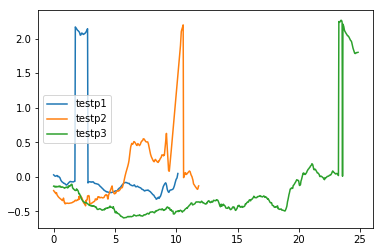

In [9]:
t7, result7 = extract_pattern(8684, 8990) #aimless
t8, result8 = extract_pattern(10464, 10822) #aimless
t9, result9 = extract_pattern(13062, 13810) #aimless

testp1 = pca_model.transform(result7)[:,0]
testp2 = pca_model.transform(result8)[:,0]
testp3 = pca_model.transform(result9)[:,0]

plt.plot(t7, testp1, label='testp1')
plt.plot(t8, testp2, label='testp2')
plt.plot(t9, testp3, label='testp3')

plt.legend()

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

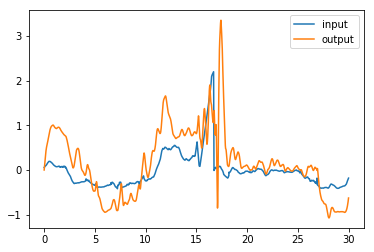

In [10]:
testp = testp2
p_all = np.hstack([p1, testp, p4])

presentation_time_test=0.00119

model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_test))
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(30)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

In [11]:
p1_len = int(len(p1)*presentation_time_test/dt)
testp_len = p1_len+int(len(testp)*presentation_time_test/dt)
p4_len = testp_len+int(len(p4)*presentation_time_test/dt)

mean1 = np.mean(sim.data[p_result][0:p1_len])
std1 = np.std(sim.data[p_result][0:p1_len])
median1 = np.median(sim.data[p_result][0:p1_len])

mean2 = np.mean(sim.data[p_result][p1_len:testp_len])
std2 = np.std(sim.data[p_result][p1_len:testp_len])
median2 = np.median(sim.data[p_result][p1_len:testp_len])

mean3 = np.mean(sim.data[p_result][testp_len:p4_len])
std3 = np.std(sim.data[p_result][testp_len:p4_len])
median3 = np.median(sim.data[p_result][testp_len:p4_len])

print("Goal Oriented Mean:   ",mean1," SD: ",std1," Median: ",median1)
print("Aimless Mean:         ",mean2," SD: ",std2," Median: ",median2)
print("No Play Mean:         ",mean3," SD: ",std3," Median: ",median3)


Goal Oriented Mean:    0.5386615067966568  SD:  0.36219657083487  Median:  0.5677280109692691
Aimless Mean:          0.31619761964742954  SD:  0.9004509593559938  Median:  0.42340895461264066
No Play Mean:          -0.14267064343773564  SD:  0.4288955216549345  Median:  0.031418057457529444
